In [32]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


def get_ground_truth(args):
    (collectionName, phoneName), df = args
    
    path = root_dir / f"train/{collectionName}/{phoneName}/ground_truth.csv"
    target_df = pd.read_csv(path)
    output_df = pd.DataFrame()
    # merge derived and target by 'millisSinceGpsEpoch'
    for epoch, epoch_df in df.groupby('millisSinceGpsEpoch'):
        idx = (target_df['millisSinceGpsEpoch'] - epoch).abs().argmin()
        epoch_diff = epoch - target_df.loc[idx, 'millisSinceGpsEpoch']
        epoch_df['epoch_diff'] = epoch_diff
        epoch_df['target_latDeg'] = target_df.loc[idx, 'latDeg']
        epoch_df['target_lngDeg'] = target_df.loc[idx, 'lngDeg']
        output_df = pd.concat([output_df, epoch_df]).reset_index(drop=True)    
    return output_df

In [2]:
# metric
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [4]:
import simdkalman

# define kf model
T = 1.0
state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0], [0, 1, 0, T, 0, 0.5 * T ** 2], [0, 0, 1, 0, T, 0],
                             [0, 0, 0, 1, 0, T], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * 1e-9
observation_model = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
observation_noise = np.diag([5e-5, 5e-5]) + np.ones((2, 2)) * 1e-9

kf = simdkalman.KalmanFilter(
        state_transition = state_transition,
        process_noise = process_noise,
        observation_model = observation_model,
        observation_noise = observation_noise)

In [5]:
def apply_kf_smoothing(df, kf_=kf):
    unique_paths = df[['collectionName', 'phoneName']].drop_duplicates().to_numpy()
    for collection, phone in tqdm(unique_paths):
        cond = np.logical_and(df['collectionName'] == collection, df['phoneName'] == phone)
        data = df[cond][['latDeg', 'lngDeg']].to_numpy()
        data = data.reshape(1, len(data), 2)
        smoothed = kf_.smooth(data)
        df.loc[cond, 'latDeg'] = smoothed.states.mean[0, :, 0]
        df.loc[cond, 'lngDeg'] = smoothed.states.mean[0, :, 1]
    return df

In [6]:
def linear_interpolation(input_df):
    dfs = pd.DataFrame()
    for (collectionName, phoneName), df in input_df.groupby(['collectionName','phoneName']):

        df['delta'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg'].shift(1), df['lngDeg'].shift(1))
        df['time_delta'] = df['millisSinceGpsEpoch'] - df['millisSinceGpsEpoch'].shift(1)
        df['delta'].fillna(0, inplace=True)
        df['time_delta'].fillna(0, inplace=True)
        df['speed'] = df['delta'] / (df['time_delta']/1000)  # m/s
        df['speed'].fillna(0, inplace=True)

        # 一度欠損値にする
        df.loc[50<df['speed'], ['latDeg', 'lngDeg']] = np.nan
        df['dummy_datetime'] = pd.to_datetime(df['millisSinceGpsEpoch'])
        df = df.set_index('dummy_datetime')

        # 時間に合わせて線形補間
        df = df.interpolate(method='time').reset_index(drop=True)
        dfs = pd.concat([dfs, df]).reset_index(drop=True)
    return dfs

In [10]:
# config
EXP_NAME = str(Path().resolve()).split('/')[-1]

In [11]:
EXP_NAME

'exp002'

In [12]:
!wandb login 1bb2d0449c11d8b987e25c38b9d8dda176310fb6

wandb: Appending key for api.wandb.ai to your netrc file: /home/user/.netrc


In [13]:
# waypointを補正したdataset
root_dir = Path('../../input/')
test_df = pd.read_csv(root_dir / "baseline_locations_test.csv")
sub_df = pd.read_csv(root_dir / 'sample_submission.csv')

## KF -> LI

In [14]:
train_df = pd.read_csv(root_dir / "baseline_locations_train.csv")

In [15]:
import multiprocessing

processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    gr = train_df.groupby(['collectionName','phoneName'])
    dfs = pool.imap_unordered(get_ground_truth, gr)
    dfs = tqdm(dfs, total=len(gr))
    dfs = list(dfs)
train_df = pd.concat(dfs).sort_values(['collectionName', 'phoneName', 'millisSinceGpsEpoch'])

  0%|          | 0/73 [00:00<?, ?it/s]

In [16]:
train_df = apply_kf_smoothing(train_df)
train_df['distance'] = calc_haversine(train_df['latDeg'],train_df['lngDeg'],
                                      train_df['target_latDeg'], train_df['target_lngDeg'])
train_df['distance'].mean()

  0%|          | 0/73 [00:00<?, ?it/s]

3.390778191301472

speedはtrainもtestも50m/s以上のものが存在してた。これは異常なのでこれを線形補間する。

In [17]:
train_df = linear_interpolation(train_df)
train_df['distance'] = calc_haversine(train_df['latDeg'],train_df['lngDeg'],train_df['target_latDeg'], train_df['target_lngDeg'])
train_df['distance'].mean()

3.2614864391449463

## LI -> KF  

In [20]:
train_df = pd.read_csv(root_dir / "baseline_locations_train.csv")
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    gr = train_df.groupby(['collectionName','phoneName'])
    dfs = pool.imap_unordered(get_ground_truth, gr)
    dfs = tqdm(dfs, total=len(gr))
    dfs = list(dfs)
train_df = pd.concat(dfs).sort_values(['collectionName', 'phoneName', 'millisSinceGpsEpoch'])

  0%|          | 0/73 [00:00<?, ?it/s]

In [21]:
train_df = linear_interpolation(train_df)
train_df['distance'] = calc_haversine(train_df['latDeg'],train_df['lngDeg'],train_df['target_latDeg'], train_df['target_lngDeg'])
train_df['distance'].mean()

3.6084284244593343

In [22]:
train_df = apply_kf_smoothing(train_df)
train_df['distance'] = calc_haversine(train_df['latDeg'],train_df['lngDeg'],
                                      train_df['target_latDeg'], train_df['target_lngDeg'])
train_df['distance'].mean()

  0%|          | 0/73 [00:00<?, ?it/s]

3.1564629632183157

## test

In [23]:
test_df = linear_interpolation(test_df)

In [24]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91486 entries, 0 to 91485
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   collectionName              91486 non-null  object 
 1   phoneName                   91486 non-null  object 
 2   millisSinceGpsEpoch         91486 non-null  int64  
 3   latDeg                      91486 non-null  float64
 4   lngDeg                      91486 non-null  float64
 5   heightAboveWgs84EllipsoidM  91486 non-null  float64
 6   phone                       91486 non-null  object 
 7   delta                       91486 non-null  float64
 8   time_delta                  91486 non-null  float64
 9   speed                       91486 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 7.0+ MB


In [25]:
test_df = apply_kf_smoothing(test_df)

  0%|          | 0/48 [00:00<?, ?it/s]

In [26]:
sub_df = sub_df.assign(
    latDeg = test_df['latDeg'],
    lngDeg = test_df['lngDeg']
)
sub_df.to_csv('submission.csv', index=False)

In [27]:
sub_df

,phone,millisSinceGpsEpoch,latDeg,lngDeg
0,2020-05-15-US-MTV-1_Pixel4,1273608785432,37.416611,-122.081959
1,2020-05-15-US-MTV-1_Pixel4,1273608786432,37.416623,-122.082009
2,2020-05-15-US-MTV-1_Pixel4,1273608787432,37.416627,-122.082040
3,2020-05-15-US-MTV-1_Pixel4,1273608788432,37.416623,-122.082060
4,2020-05-15-US-MTV-1_Pixel4,1273608789432,37.416621,-122.082070
...,...,...,...,...
91481,2021-04-29-US-SJC-3_SamsungS20Ultra,1303763185000,37.334542,-121.899389
91482,2021-04-29-US-SJC-3_SamsungS20Ultra,1303763186000,37.334544,-121.899381
91483,2021-04-29-US-SJC-3_SamsungS20Ultra,1303763187000,37.334546,-121.899373
91484,2021-04-29-US-SJC-3_SamsungS20Ultra,1303763188000,37.334550,-121.899365


In [28]:
_sub = pd.read_csv(root_dir/'kf_sample_sub.csv')

In [35]:
_x = _sub.loc[_sub['phone']=='2020-05-15-US-MTV-1_Pixel4', 'latDeg']
_y = _sub.loc[_sub['phone']=='2020-05-15-US-MTV-1_Pixel4', 'lngDeg']

In [36]:
x = sub_df.loc[sub_df['phone']=='2020-05-15-US-MTV-1_Pixel4', 'latDeg']
y = sub_df.loc[sub_df['phone']=='2020-05-15-US-MTV-1_Pixel4', 'lngDeg']

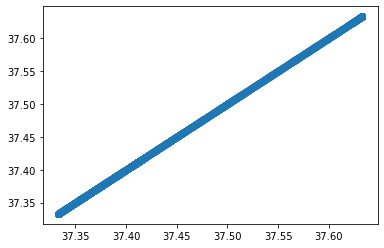

In [37]:
plt.scatter(x, _x)

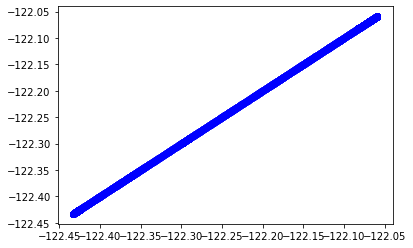

In [38]:
plt.scatter(y, _y, color='blue')

<AxesSubplot:>

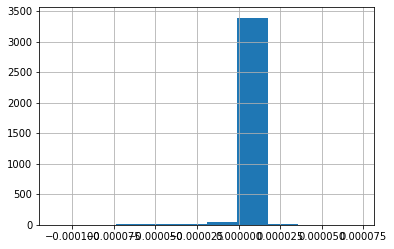

In [40]:
(x - _x).hist()

<AxesSubplot:>

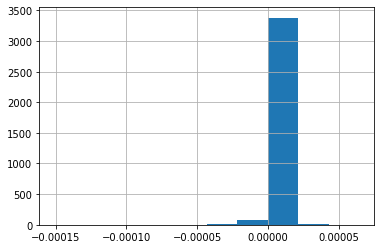

In [41]:
(y - _y).hist()